<a href="https://colab.research.google.com/github/CUKykkim/bigdata_processing_3rd_flume/blob/main/bigdata_processing_3rd_week_flume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flume 수행 환경 설정

**Flume 다운로드 받기**

1. **다음 도커 명렁어를 통해 Flume을 다운로드 받고, 받는 즉시 수행시킨다.**



```
docker run \
  --env FLUME_AGENT_NAME=docker \
  --volume /tmp/config.conf:/opt/flume-config/flume.conf \
  --detach \
  ykkim77/flume-cuk:latest
```





**2. 우분투 쉘을 하나 더 열고, Flume 도커 컨테이너 내부로 진입한다.**

docker ps를 명령어를 통해 수행중인 컨테이너의 ID 값을 확인할 수 있다.



```
docker ps
```



```
ContainerID
8c699d95ca1c   probablyfine/flume:latest  "start-flume" 2 hours ago  Up 2
```



```
docker exec -it ContainerID /bin/bash
```




#Flume 수행하기

## 디렉토리의 파일을 소스로 데이터 수집하기

**1. 우분투의 /opt/flume/conf 에서 flume-conf.properties 를 작성한다.**



윈도우 메모장과 같은 기능을 하는 vi 편집기를 이용하여 flume-conf.properties를 연다.

```
vi flume-conf.properties
```

<strong> vi 편집기를 연 상태에서 영문자 a를 눌러주면 편집모드로 되고, 
esc 를 누르면 다시 읽기 모드로 전환된다. </strong>



```
#source, sink, channel 의 이름 설정

agent1.sources = source_1
agent1.sinks = sink_1
agent1.channels = channel_1

# source와 sink는 채널과 연결되어야 하는데, 이때 어떤 source와 sink가 어떤 채널에 연결될지 지정해 준다. 

agent1.sources.source_1.channels = channel_1
agent1.sinks.sink_1.channel = channel_1



agent1.sources.source_1.type = spooldir  # source type을 디렉토리로 설정한다.
agent1.sources.source_1.spoolDir = /home/cuk_practice/test  # source 디렉토리 경로를 설정한다.

agent1.sinks.sink_1.type = logger # sink_type을 로그로 설정한다.

agent1.channels.channel_1.type = file  
```


<strong> esc를 눌러 읽기 모드로 전환한 뒤,   :wq  또는 :q!  명령어를 눌러주고 편집기를 빠져나온다. </strong>


<strong> 2. 수집될 디렉토리를 만든다. </strong>



```
mkdir -p /home/cuk_practice/test
```



<strong>3. /opt/flume/conf 디렉토리상에서 다음 명령어를 입력하여 flume으로 데이터 수집을 수행한다. <strong>



```
flume-ng agent -n agent1 -c /opt/flume/conf -f flume-conf.properties -Dflume.root.logger=INFO,console
```



<strong>4. /home/cuk_practice/test 상에서 파일을 생성해 본다.<strong>



```
echo "Hello cuk user" > ./test1.txt
```



**5. logger 방식으로 실시간으로 생성된 파일의 내용을 수집된 것을 console로 확인가능 하다.** <br>

터미널을 2개 열어 하나는 flume 수행, 다른 하나는 파일을 생성하는 것으로 사용한다.

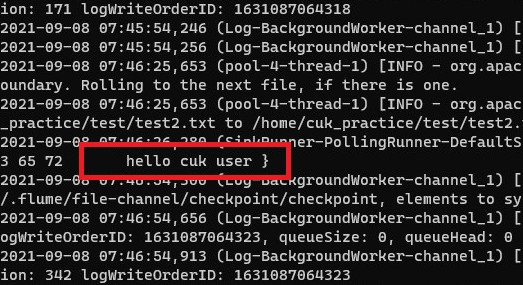


## 특정 포트로 메시지 보내기

<strong> 1. 우분투의 /opt/flume/conf 에서 flume-conf2.properties 를 작성한다. </strong>



```
#source, sink, channel 의 이름 설정
agent1.sources = s1
agent1.sinks = k1
agent1.channels = c1

# source와 sink는 채널과 연결되어야 하는데, 이때 어떤 source와 sink가 어떤 채널에 연결될지 지정해 준다. 

agent1.sources.s1.channels = c1
agent1.sinks.k1.channel = c1

agent1.sources.s1.type = netcat  # source type을 네트워크 메시지로 한다.
agent1.sources.s1.bind = localhost  # 이때 소스의 아이피를 설정
agent1.sources.s1.port = 12345      # 소스의 포트를 설정

agent1.sinks.k1.type = logger     #sink_type을 로그로 설정한다

agent1.channels.c1.type = memory
```



<strong>3. /opt/flume/conf 디렉토리상에서 다음 명령어를 입력하여 flume으로 데이터 수집을 수행한다. <strong>



```
flume-ng agent -n agent1 -c /opt/flume/conf -f flume-conf2.properties -Dflume.root.logger=INFO,console
```

<strong> 4. telnet 을 수행하여 실시간으로 12345 번 포트로 메시지를 송신한다. </strong>



```
telnet localhost 12345
```

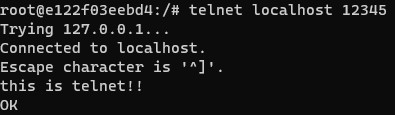







<strong> 5. flume agent 쪽에서 telnet으로 보낸 메세지를 수집했는지 확인한다. </strong>

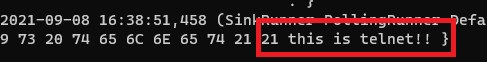




## 멀티 Agent 만들기






Agent1 에서 Agent2로 데이터를 전달하는 멀티 Agent를 만들어 보기

Agent1에서 시스템의 로그를 읽은뒤 Agent2로 전달

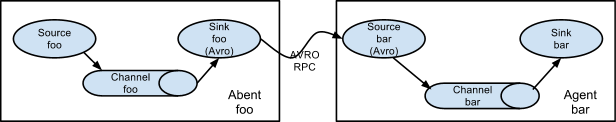

**agent1 만들기**


<strong> 1. 우분투의 /opt/flume/conf 에서 flume-conf3-1.properties 를 작성한다. </strong>



```
agent1.sources = s1
agent1.sinks = k1
agent1.channels = c1

agent1.sources.s1.channels = c1
agent1.sinks.k1.channel = c1

agent1.sources.s1.type = exec
agent1.sources.s1.command = tail -f /var/log/alternatives.log


agent1.sinks.k1.type = avro
agent1.sinks.k1.hostname = localhost
agent1.sinks.k1.port = 10000

agent1.channels.c1.type = memory
agent1.channels.c1.capacity = 1000
```




<strong> 2. 우분투의 /opt/flume/conf 에서 flume-conf3-2.properties 를 작성한다. </strong>




```
agent2.sources = s2
agent2.sinks = k2
agent2.channels = c2

agent2.sources.s2.channels = c2
agent2.sinks.k2.channel = c2

agent2.sources.s2.type = avro
agent2.sources.s2.bind = localhost
agent2.sources.s2.port = 10000


agent2.sinks.k2.type = logger


agent2.channels.c2.type = memory
agent2.channels.c2.capacity = 1000
```






<strong>3. agent2 부터 먼저 수행한다. </strong>



```
flume-ng agent -n agent2 -c /opt/flume/conf -f flume-conf3-2.properties -Dflume.root.logger=INFO,console
```



<strong>4. agent1을 수행한다. </strong>



```
flume-ng agent -n agent1 -c /opt/flume/conf -f flume-conf3-1.properties -Dflume.root.logger=INFO,console
```

<strong>5. agent2의 console을 확인해 본다. </strong>

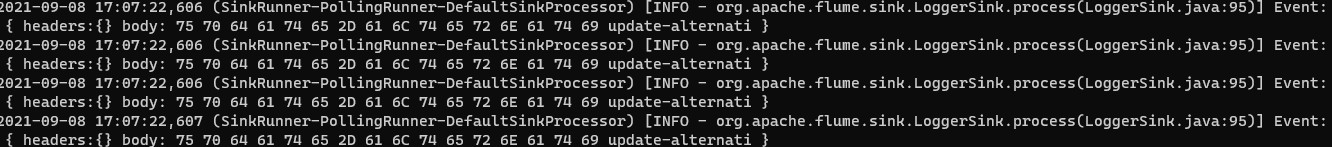
